# \[STBDA\] 07wk: Logistic regression

김보람  
2023-06-26

> 해당 강의노트는 전북대학교 최규빈교수님
> [STBDA2022](https://guebin.github.io/STBDA2022/) 자료임

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

2023-06-26 15:05:17.002455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

In [2]:
tnp.experimental_enable_numpy_behavior()

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }')

### piece-wise linear regression

model:
$y_i=\begin{cases} x_i +0.3\epsilon_i & x\leq 0 \\ 3.5x_i +0.3\epsilon_i & x>0 \end{cases}$

In [4]:
np.random.seed(43052)
N=100
x = np.linspace(-1,1,N)
lamb = lambda x: x*1+np.random.normal()*0.3 if x<0 else x*3.5+np.random.normal()*0.3
y= np.array(list(map(lamb,x)))
y

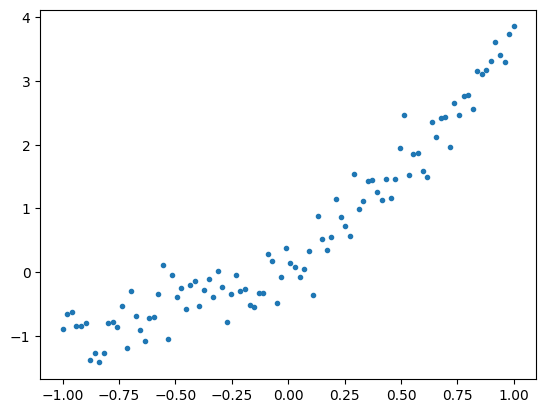

In [5]:
plt.plot(x,y,'.')

#### 풀이1: 단순회귀모형

In [6]:
x= x.reshape(N,1)
y= y.reshape(N,1)

In [7]:
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1))
net.compile(optimizer=tf.optimizers.SGD(0.1),loss='mse')
net.fit(x,y,batch_size=N,epochs=1000,verbose=0) # numpy로 해도 돌아감

In [8]:
net.weights

In [9]:
yhat = x * 2.2616348 + 0.6069048
yhat = net.predict(x)

4/4 [==============================] - 0s 502us/step

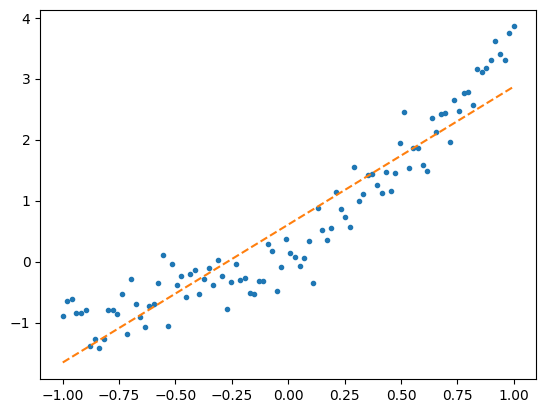

In [10]:
plt.plot(x,y,'.')
plt.plot(x,yhat,'--')

`-` 실패: 이 모형은 epoch을 10억번 돌려도 실패할 모형임 - 왜? 아키텍처
설계자체가 틀렸음 - 꺽인부분을 표현하기에는 아키텍처의 표현력이 너무
부족하다 -\> under fit의 문제

#### 풀이2: 비선형 활성화 함수의 도입

`-` 여기에서 비선형 활성화 함수는 relu

`-` 네트워크를 아래와 같이 수정하자.

(수정전) hat은 생략

In [11]:
#collapse
gv('''
"x" -> "x*w,    bias=True"[label="*w"] ;
"x*w,    bias=True" -> "y"[label="indentity"] ''')


(수정후) hat은 생략

In [12]:
#collapse
gv('''
"x" -> "x*w,    bias=True"[label="*w"] ;
"x*w,    bias=True" -> "y"[label="relu"] ''')


-   마지막에 $f(x)=x$ 라는 함수대신에 relu를 취하는 것으로 구조를 약간
    변경
-   활성화함수(acitivation function)를 indentity에서 relu로 변경

`-` relu함수란?

In [13]:
_x = np.linspace(-1,1,100)
tf.nn.relu(_x)

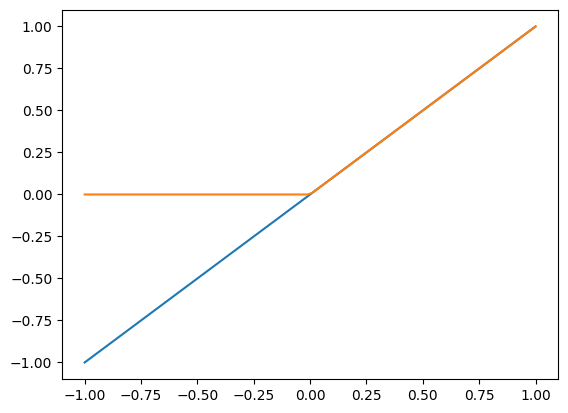

In [14]:
plt.plot(_x,_x)
plt.plot(_x,tf.nn.relu(_x))

-   파란색을 주황색으로 바꿔주는 것이 렐루함수임
-   $f(x)=\max(0,x)=\begin{cases} 0 & x\leq 0 \\ x & x>0 \end{cases}$

`-` 아키텍처: $\hat{y}_i=relu(\hat{w}_0+\hat{w}_1x_i)$,
$relu(x)=\max(0,x)$

`-` 풀이시작

**1단계**

In [15]:
net2 = tf.keras.Sequential()

**2단계**

In [16]:
tf.random.set_seed(43053)
l1 = tf.keras.layers.Dense(1, input_shape=(1,))
a1 = tf.keras.layers.Activation(tf.nn.relu)

In [17]:
net2.add(l1)

In [18]:
net2.layers

In [19]:
net2.add(a1)

In [20]:
net2.layers

In [21]:
l1.get_weights()

In [22]:
net2.get_weights()

(네트워크 상황 확인)

In [23]:
u1= l1(x)
#u1= x@l1.weights[0] + l1.weights[1]

In [24]:
v1= a1(u1)
#v1= tf.nn.relu(u1)

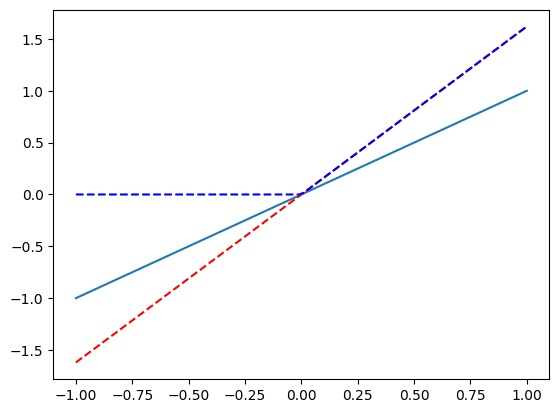

In [25]:
plt.plot(x,x)
plt.plot(x,u1,'--r')
plt.plot(x,v1,'--b')

**3단계**

In [26]:
net2.compile(optimizer=tf.optimizers.SGD(0.1),loss='mse')

**4단계**

In [27]:
net2.fit(x,y,epochs=1000,verbose=0,batch_size=N)

`-` result

In [28]:
yhat = tf.nn.relu(x@l1.weights[0] + l1.weights[1])
yhat = net2.predict(x)
yhat = net2(x)
yhat = a1(l1(x))
yhat = net2.layers[1](net2.layers[0](x))

4/4 [==============================] - 0s 519us/step

-   위는 다 같은 코드.

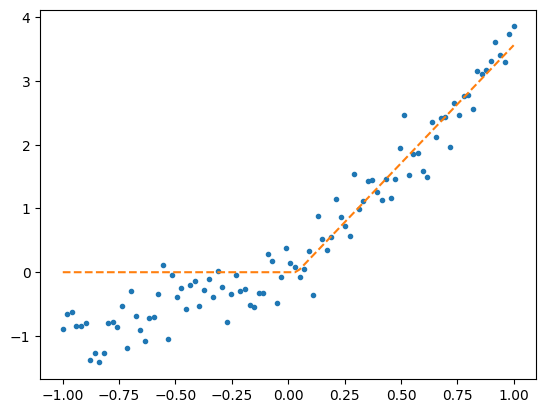

In [29]:
plt.plot(x,y,'.')
plt.plot(x,yhat,'--')

`-` discussion - 이것 역시 수백억번 에폭을 반복해도 이 이상 적합이
힘들다 $\to$ 모형의 표현력이 떨어진다. - 해결책: 주황색점선이 2개 있다면
어떨까?

#### 풀이3: 노드수추가 + 레이어추가

목표: 2개의 주황색 점선을 만들자.

**1단계**

In [30]:
net3 = tf.keras.Sequential()

**2단계**

In [31]:
tf.random.set_seed(43053)
l1 = tf.keras.layers.Dense(2,input_shape=(1,)) # 2로 하면 직선이 두개
a1 = tf.keras.layers.Activation(tf.nn.relu)

In [32]:
net3.add(l1)
net3.add(a1)

(네트워크 상황 확인)

In [33]:
l1(x).shape
# l1(x) : (100,1) -> (100,2)

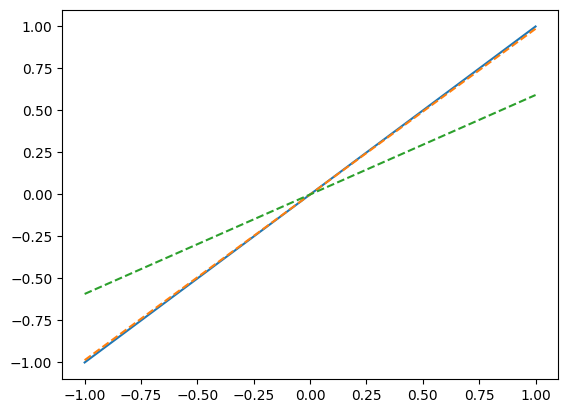

In [34]:
plt.plot(x,x)
plt.plot(x,l1(x),'--')

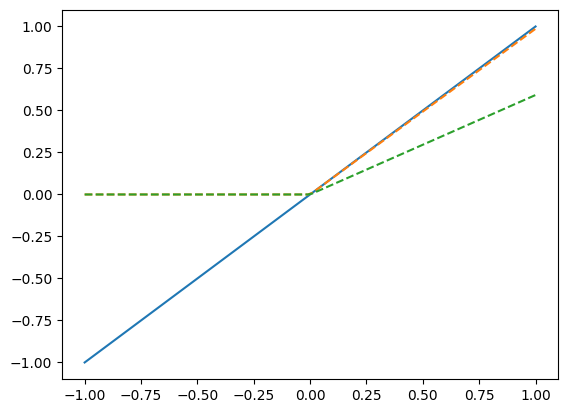

In [35]:
plt.plot(x,x)
plt.plot(x,a1(l1(x)),'--')

`-` 이 상태에서는 yhat이 안나온다. 왜? - 차원이 안맞음. `a1(l1(x))`의
차원은 (N,2)인데 최종적인 yhat의 차원은 (N,1)이어야 함. - 차원이
어찌저찌 맞다고 쳐도 relu를 통과하면 항상 yhat\>0 임. 따라서 음수값을
가지는 y는 0으로 밖에 맞출 수 없음.

`-` 해결책: a1(l1(x))에 연속으로(Sequential하게!) 또 다른 레이어를 설계!
(N,2) -\> (N,1) 이 되도록! -
`yhat= bias + weight1 * a1(l1(x))[0] + weight2 * a1(l1(x))[1]`

`-` 즉 a1(l1(x)) 를 새로운 입력으로 해석하고 출력을 만들어주는
선형모형을 다시태우면 된다. - 입력차원: 2 - 출력차원: 1

In [36]:
net3.layers

In [37]:
tf.random.set_seed(43053)
l2 = tf.keras.layers.Dense(1, input_shape=(2,))

In [38]:
net3.add(l2)

In [39]:
net3.layers

In [40]:
net3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________

`-` 추정해야할 파라메터수가 4,0,3으로 나온다.

`-` 수식표현:
$X \to X@W^{(1)}+b^{(1)} \to relu(X@W^{(1)}+b^{(1)}) \to relu(X@W^{(1)}+b^{(1)})@W^{(2)}+b^{(2)}=yhat$

-   $X$: (N,1)
-   $W^{(1)}$: (1,2) ==\> 파라메터 2개 추정
-   $b^{(1)}$: (2,) ==\> 파라메터 2개가 추가 // 여기까지 추정할
    파라메터는 4개
-   $W^{(2)}$: (2,1) ==\> 파라메터 2개 추정
-   $b^{(2)}$: (1,) ==\> 파라메터 1개가 추가 // 따라서 3개

`-` 참고: 추정할 파라메터수가 많다 = 복잡한 모형이다. - 초거대AI: 추정할
파라메터수가 엄청 많은..

In [43]:
net3.weights

In [44]:
l1.weights

In [45]:
l2.weights

`-` 좀 더 간단한 수식표현:
$X \to (u_1 \to v_1) \to (u_2 \to v_2) = yhat$ -
$u_1= X@W^{(1)}+b^{(1)}$ - $v_1= relu(u_1)$ -
$u_2= v_1@W^{(2)}+b^{(2)}$ - $v_2= indentity(u_2):=yhat$

In [46]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "u1[:,0]"[label="*W1[0,0]"]
    "X" -> "u1[:,1]"[label="*W1[0,1]"]
    "u1[:,0]" -> "v1[:,0]"[label="relu"]
    "u1[:,1]" -> "v1[:,1]"[label="relu"]
    label = "Layer 1"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "v1[:,0]" -> "yhat"[label="*W2[0,0]"]
    "v1[:,1]" -> "yhat"[label="*W2[1,0]"]
    label = "Layer 2"
}
''')


In [47]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "node1"
    "X" -> "node2"
    label = "Layer 1: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "yhat"
    "node2" -> "yhat"
    label = "Layer 2"
}
''')

**3단계**

In [48]:
net3.compile(loss='mse',optimizer=tf.optimizers.SGD(0.1))

**4단계**

In [49]:
net3.fit(x,y,epochs=1000,verbose=0, batch_size=N)

`-` 결과확인

In [50]:
net3.weights

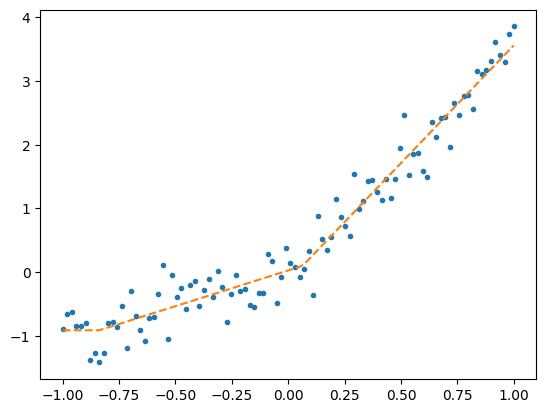

In [51]:
plt.plot(x,y,'.')
plt.plot(x,net3(x),'--')

`-` 분석

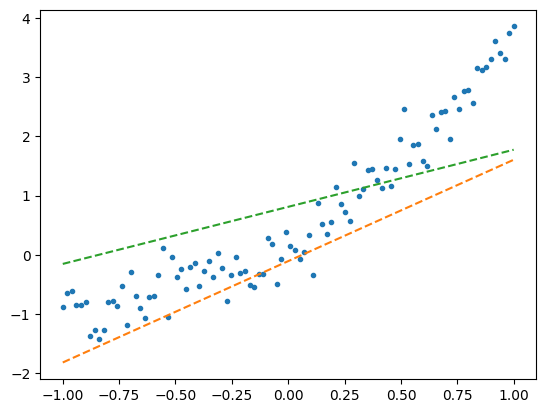

In [52]:
plt.plot(x,y,'.')
plt.plot(x,l1(x),'--')

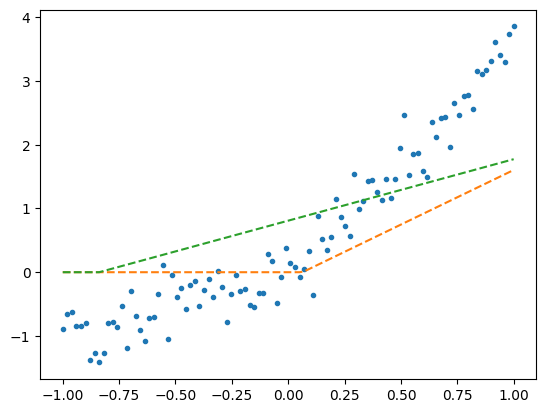

In [53]:
plt.plot(x,y,'.')
plt.plot(x,a1(l1(x)),'--')

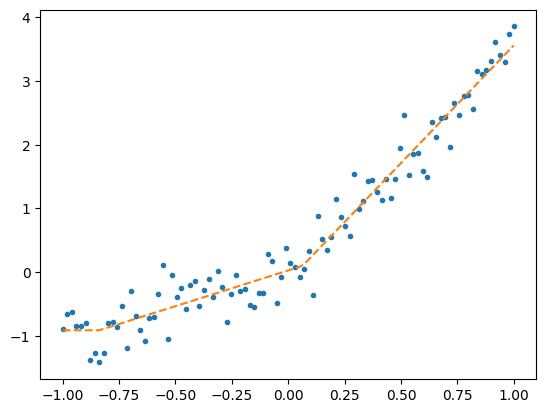

In [54]:
plt.plot(x,y,'.')
plt.plot(x,l2(a1(l1(x))),'--')

`-` 마지막 2개의 그림을 분석

In [136]:
l2.weights

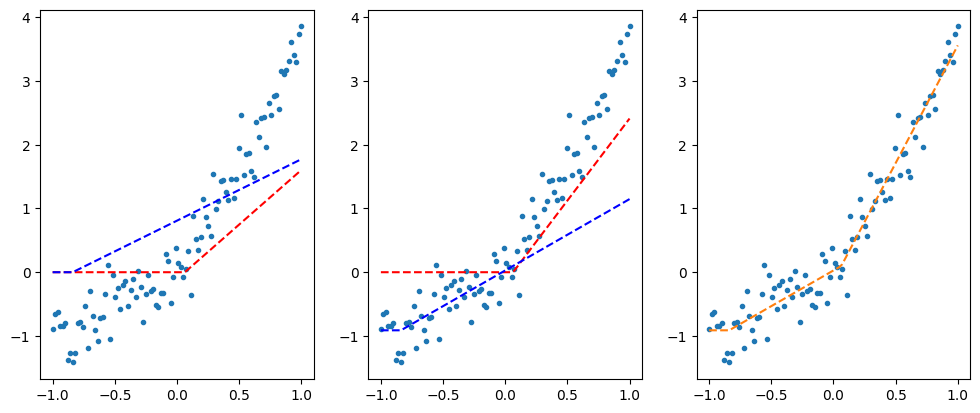

In [64]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_figwidth(12)
ax1.plot(x,y,'.')
ax1.plot(x,a1(l1(x))[:,0],'--r')
ax1.plot(x,a1(l1(x))[:,1],'--b')
ax2.plot(x,y,'.')
ax2.plot(x,a1(l1(x))[:,0]*1.5033181,'--r')
ax2.plot(x,a1(l1(x))[:,1]*(1.1611973)-0.9116387,'--b')
ax3.plot(x,y,'.')
ax3.plot(x,a1(l1(x))[:,0]*1.5033181+a1(l1(x))[:,1]*(1.1611973)-0.9116387,'--')



#### 풀이3의 실패

In [67]:
tf.random.set_seed(43054)
## 1단계
net3 = tf.keras.Sequential()
## 2단계
net3.add(tf.keras.layers.Dense(2))
net3.add(tf.keras.layers.Activation('relu'))
net3.add(tf.keras.layers.Dense(1))
## 3단계
net3.compile(optimizer=tf.optimizers.SGD(0.1),loss='mse')
## 4단계
net3.fit(x,y,epochs=1000,verbose=0,batch_size=N)

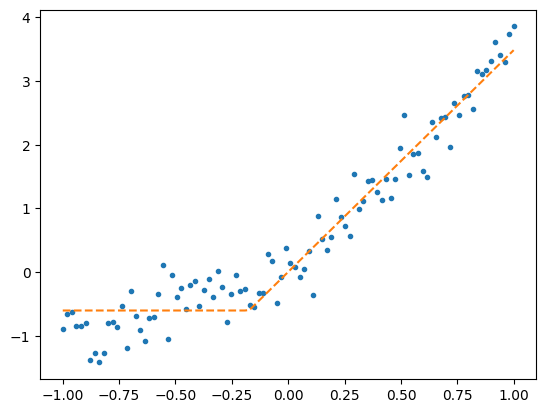

In [68]:
plt.plot(x,y,'.')
plt.plot(x,net3(x),'--')

`-` 엥? 에폭이 부족한가?

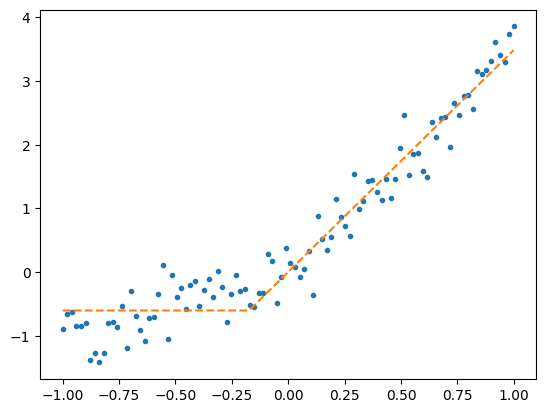

In [69]:
net3.fit(x,y,epochs=10000,verbose=0,batch_size=N)
plt.plot(x,y,'.')
plt.plot(x,net3(x),'--')

`-` 실패분석

In [70]:
l1,a1,l2 = net3.layers

In [71]:
l2.weights

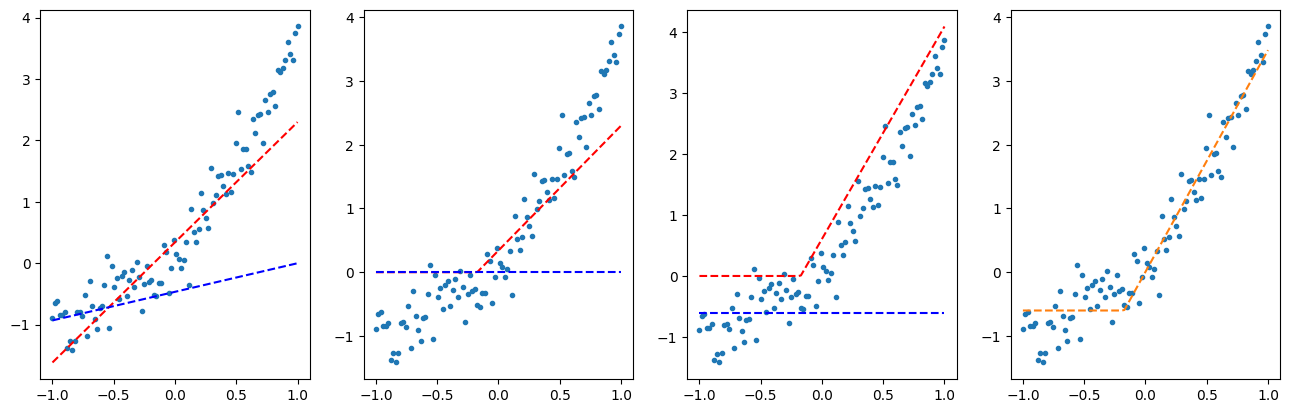

In [72]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4)
fig.set_figwidth(16)
ax1.plot(x,y,'.')
ax1.plot(x,l1(x)[:,0],'--r')
ax1.plot(x,l1(x)[:,1],'--b')
ax2.plot(x,y,'.')
ax2.plot(x,a1(l1(x))[:,0],'--r')
ax2.plot(x,a1(l1(x))[:,1],'--b')
ax3.plot(x,y,'.')
ax3.plot(x,a1(l1(x))[:,0]*1.7770029,'--r')
ax3.plot(x,a1(l1(x))[:,1]*(-0.7268499)+(-0.60076195),'--b')
ax4.plot(x,y,'.')
ax4.plot(x,a1(l1(x))[:,0]*1.7770029+a1(l1(x))[:,1]*(-0.7268499)+(-0.60076195),'--')

-   보니까 파란색선이 하는 역할을 없음
-   그런데 생각해보니까 이 상황에서는 파란색선이 할수 있는 일이 별로
    없음
-   왜? 지금은 나름 빨간색선에 의해서 최적화가 된 상태임 $\to$ 빨간선이
    뭔가 하려고하면 최적화된 상태가 깨질 수 있음 (loss 증가)
-   즉 이 상황 자체가 나름 최적회된 상태이다. 이러한 현상을 “global
    minimum을 찾지 못하고 local minimum에 빠졌다”라고 표현한다.

확인:

In [73]:
net3.weights

In [74]:
W1= tf.Variable(tnp.array([[1.9579618,  0.46560898 ]]))
b1= tf.Variable(tnp.array([0.34100613,  -0.4658857 ]))
W2= tf.Variable(tnp.array([[1.7770029],[-0.7268499 ]]))
b2= tf.Variable(tnp.array([-0.60076195]))

In [75]:
with tf.GradientTape() as tape:
    u = tf.constant(x) @ W1 + b1
    v = tf.nn.relu(u)
    yhat = v@W2 + b2
    loss = tf.losses.mse(y,yhat)

In [76]:
tape.gradient(loss,[W1,b1,W2,b2])

예상대로 계수값이 거의 다 0이다.

#### 풀이4: 노드수를 더 추가한다면?

`-` 노드수를 더 추가해보면 어떻게 될까? (주황색 점선이 더 여러개
있다면?)

In [77]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "node1"
    "X" -> "node2"
    "X" -> "..."
    "X" -> "node512"
    label = "Layer 1: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "yhat"
    "node2" -> "yhat"
    "..." -> "yhat"
    "node512" -> "yhat"
    label = "Layer 2"
}
''')

In [78]:
tf.random.set_seed(43056)
net4= tf.keras.Sequential()
net4.add(tf.keras.layers.Dense(512,activation='relu')) # 이렇게 해도됩니다.
net4.add(tf.keras.layers.Dense(1))
net4.compile(loss='mse',optimizer=tf.optimizers.SGD(0.1))
net4.fit(x,y,epochs=1000,verbose=0,batch_size=N)

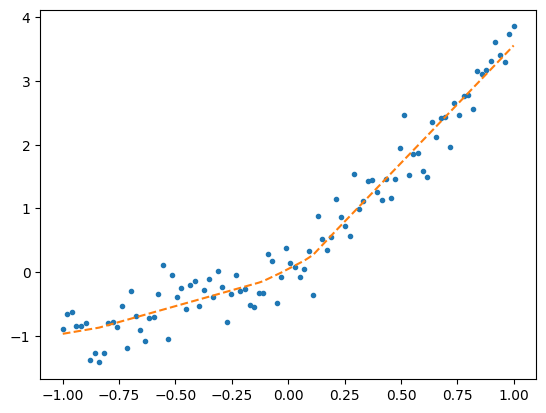

In [79]:
plt.plot(x,y,'.')
plt.plot(x,net4(x),'--')

-   잘된다..
-   한두개의 노드가 역할을 못해도 다른노드들이 잘 보완해주는듯!

`-` 노드수가 많으면 무조건 좋다? -\> 대부분 나쁘지 않음. 그런데 종종
맞추지 말아야할것도 맞춤.. (overfit)

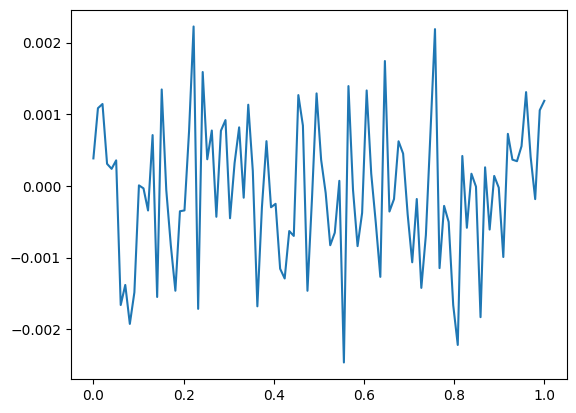

In [80]:
np.random.seed(43052)
N=100
_x = np.linspace(0,1,N).reshape(N,1)
_y = np.random.normal(loc=0,scale=0.001,size=(N,1))
plt.plot(_x,_y)

In [81]:
tf.random.set_seed(43052)
net4 = tf.keras.Sequential()
net4.add(tf.keras.layers.Dense(512,activation='relu'))
net4.add(tf.keras.layers.Dense(1))
net4.compile(loss='mse',optimizer=tf.optimizers.SGD(0.5))
net4.fit(_x,_y,epochs=1000,verbose=0,batch_size=N)

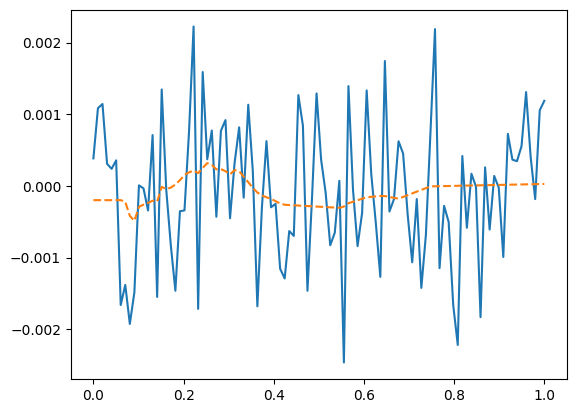

In [82]:
plt.plot(_x,_y)
plt.plot(_x,net4(_x),'--')

-   이 예제는 추후 다시 공부할 예정

### Logistic regression

#### motive

`-` 현실에서 이런 경우가 많음 - $x$가 커질수록 (혹은 작아질수록)
성공확률이 올라간다.

`-` 이러한 모형은 아래와 같이 설계할 수 있음 \<– 외우세요!! -
$y_i \sim Ber(\pi_i)$, where
$\pi_i=\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$

-   $\hat{y}_i =\frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+exp(-\hat{w}_0-\hat{w}_1x_i)}$

-   $loss=-\frac{1}{n}\sum_{i=1}^{n}\big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$

`-` 위와 같은 손실함수를 BCEloss라고 부른다. (BCE는 Binary Cross
Entropy의 약자)

#### 예제

In [83]:
N = 2000

In [85]:
x = tnp.linspace(-1,1,N).reshape(N,1)
w0 = -1
w1 = 5
u = w0 + x*w1
#v = tf.constant(np.exp(u)/(1+np.exp(u))) # v=πi
v = tf.nn.sigmoid(u)
y = tf.constant(np.random.binomial(1,v),dtype=tf.float64)

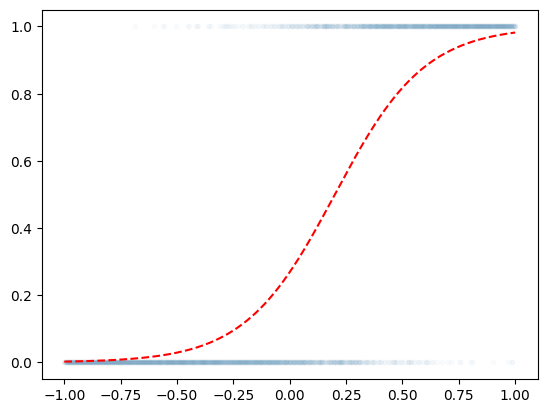

In [86]:
plt.plot(x,y,'.',alpha=0.02)
plt.plot(x,v,'--r')

`-` 이 아키텍처(yhat을 얻어내는 과정)를 다어어그램으로 나타내면 아래와
같다.

In [87]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x" -> "x*w, bias=True"[label="*w"]
    "x*w, bias=True" -> "yhat"[label="sigmoid"]
    label = "Layer 1"
}
''')

`-` 또는 간단하게 아래와 같이 쓸 수 있다.

In [88]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    x
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    x -> "node1=yhat"
    label = "Layer 1: sigmoid"
}
''')

`-` 케라스를 이용하여 적합을 해보면

-   $loss=-\frac{1}{n}\sum_{i=1}^{n}\big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$

In [89]:
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
bceloss_fn = lambda y,yhat: -tf.reduce_mean(y*tnp.log(yhat) + (1-y)*tnp.log(1-yhat))
net.compile(loss=bceloss_fn, optimizer=tf.optimizers.SGD(0.1))
net.fit(x,y,epochs=1000,verbose=0,batch_size=N)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089

In [90]:
net.weights

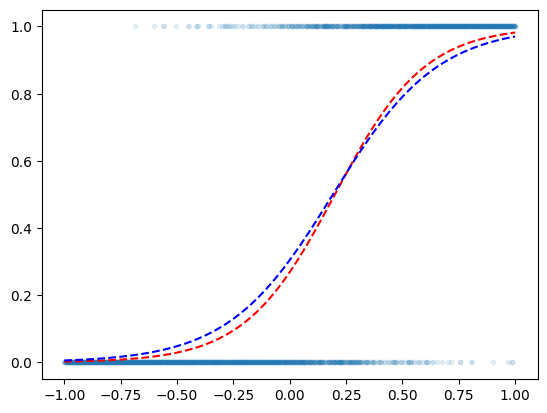

In [91]:
plt.plot(x,y,'.',alpha=0.1)
plt.plot(x,v,'--r')
plt.plot(x,net(x),'--b')

#### MSE loss?

`-` mse loss를 쓰면 왜 안되는지?

In [92]:
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
mseloss_fn = lambda y,yhat: tf.reduce_mean((y-yhat)**2)
net.compile(loss=mseloss_fn, optimizer=tf.optimizers.SGD(0.1))
net.fit(x,y,epochs=1000,verbose=0,batch_size=N)

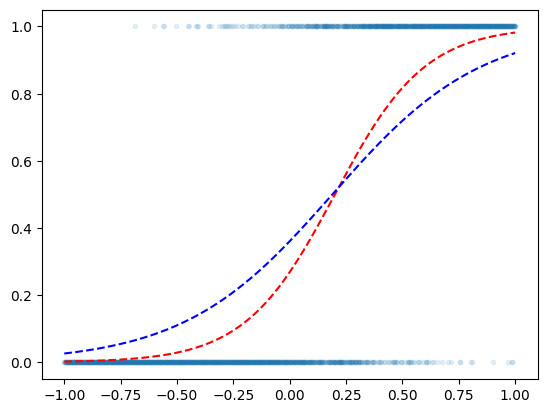

In [93]:
plt.plot(x,y,'.',alpha=0.1)
plt.plot(x,v,'--r')
plt.plot(x,net(x),'--b')

-   일단 BCE loss와 비교해보니까 동일 초기값, 동일 epochs에서 적합이
    별로임

#### MSE loss vs BCE loss

`-` MSEloss, BCEloss의 시각화

In [94]:
w0, w1 = np.meshgrid(np.arange(-10,3,0.2), np.arange(-1,10,0.2), indexing='ij')
w0, w1 = w0.reshape(-1), w1.reshape(-1)

def loss_fn1(w0,w1):
    u = w0+w1*x
    yhat = np.exp(u)/(np.exp(u)+1)
    return mseloss_fn(y,yhat)

def loss_fn2(w0,w1):
    u = w0+w1*x
    yhat = np.exp(u)/(np.exp(u)+1)
    return bceloss_fn(y,yhat)

loss1 = list(map(loss_fn1,w0,w1))
loss2 = list(map(loss_fn2,w0,w1))

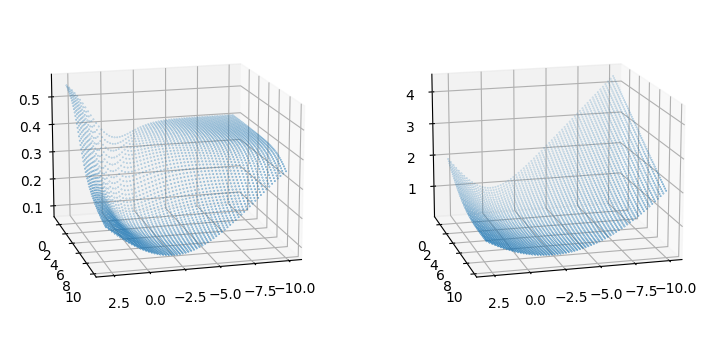

In [95]:
fig = plt.figure()
fig.set_figwidth(9)
fig.set_figheight(9)
ax1=fig.add_subplot(1,2,1,projection='3d')
ax2=fig.add_subplot(1,2,2,projection='3d')
ax1.elev=15
ax2.elev=15
ax1.azim=75
ax2.azim=75
ax1.scatter(w0,w1,loss1,s=0.1)
ax2.scatter(w0,w1,loss2,s=0.1)

-   왼쪽곡면(MSEloss)보다 오른쪽곡면(BCEloss)이 좀더 예쁘게 생김 -\>
    오른쪽 곡면에서 더 학습이 잘될것 같음

#### 학습과정 시각화예시1

`-` 파라메터학습과정 시각화 // 옵티마이저: SGD, 초기값: (w0,w1) =
(-3.0,-1.0)

1.  데이터정리

In [96]:
X = tf.concat([tf.ones(N,dtype=tf.float64).reshape(N,1),x],axis=1)
X

1.  1ter돌려봄

In [97]:
net_mse = tf.keras.Sequential()
net_mse.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid'))
net_mse.compile(optimizer=tf.optimizers.SGD(0.1),loss=mseloss_fn)
net_mse.fit(X,y,epochs=1,batch_size=N)

1/1 [==============================] - 0s 85ms/step - loss: 0.2281

In [98]:
net_bce = tf.keras.Sequential()
net_bce.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid'))
net_bce.compile(optimizer=tf.optimizers.SGD(0.1),loss=bceloss_fn)
net_bce.fit(X,y,epochs=1,batch_size=N)

1/1 [==============================] - 0s 94ms/step - loss: 0.7711

In [99]:
net_mse.get_weights(), net_bce.get_weights()

In [100]:
net_mse.set_weights([tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)])
net_bce.set_weights([tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)])

In [101]:
net_mse.get_weights(), net_bce.get_weights()

1.  학습과정기록: 15에폭마다 기록

In [102]:
What_mse = tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)
What_bce = tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)

In [103]:
for k in range(29):
    net_mse.fit(X,y,epochs=15,batch_size=N,verbose=0)
    net_bce.fit(X,y,epochs=15,batch_size=N,verbose=0)
    What_mse = tf.concat([What_mse,net_mse.weights[0]],axis=1)
    What_bce = tf.concat([What_bce,net_bce.weights[0]],axis=1)

1.  시각화

In [104]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

In [105]:
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
fig.suptitle("SGD, Winit=(-3,-1)")
ax1=fig.add_subplot(2,2,1,projection='3d')
ax2=fig.add_subplot(2,2,2,projection='3d')
ax1.elev=15;ax2.elev=15;ax1.azim=75;ax2.azim=75
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

ax1.scatter(w0,w1,loss1,s=0.1);ax1.scatter(-1,5,loss_fn1(-1,5),color='red',marker='*',s=200)
ax2.scatter(w0,w1,loss2,s=0.1);ax2.scatter(-1,5,loss_fn2(-1,5),color='red',marker='*',s=200)

ax3.plot(x,y,','); ax3.plot(x,v,'--r');
line3, = ax3.plot(x,1/(1+np.exp(-X@What_mse[:,0])),'--b')
ax4.plot(x,y,','); ax4.plot(x,v,'--r')
line4, = ax4.plot(x,1/(1+np.exp(-X@What_bce[:,0])),'--b')

def animate(i):
    _w0_mse,_w1_mse = What_mse[:,i]
    _w0_bce,_w1_bce = What_bce[:,i]
    ax1.scatter(_w0_mse, _w1_mse, loss_fn1(_w0_mse, _w1_mse),color='gray')
    ax2.scatter(_w0_bce, _w1_bce, loss_fn2(_w0_bce, _w1_bce),color='gray')
    line3.set_ydata(1/(1+np.exp(-X@What_mse[:,i])))
    line4.set_ydata(1/(1+np.exp(-X@What_bce[:,i])))

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

#### 학습과정 시각화예시2

`-` 파라메터학습과정 시각화 // 옵티마이저: Adam, 초기값: (w0,w1) =
(-3.0,-1.0)

1.  데이터정리

In [106]:
X = tf.concat([tf.ones(N,dtype=tf.float64).reshape(N,1),x],axis=1)
X

1.  1ter돌려봄

In [107]:
net_mse = tf.keras.Sequential()
net_mse.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid'))
net_mse.compile(optimizer=tf.optimizers.Adam(0.1),loss=mseloss_fn)
net_mse.fit(X,y,epochs=1,batch_size=N)

1/1 [==============================] - 0s 102ms/step - loss: 0.3403

In [108]:
net_bce = tf.keras.Sequential()
net_bce.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid'))
net_bce.compile(optimizer=tf.optimizers.Adam(0.1),loss=bceloss_fn)
net_bce.fit(X,y,epochs=1,batch_size=N)

1/1 [==============================] - 0s 106ms/step - loss: 0.8690

In [109]:
net_mse.get_weights(), net_bce.get_weights()

In [110]:
net_mse.set_weights([tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)])
net_bce.set_weights([tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)])

In [111]:
net_mse.get_weights(), net_bce.get_weights()

1.  학습과정기록: 15에폭마다 기록

In [112]:
What_mse = tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)
What_bce = tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)

In [113]:
for k in range(29):
    net_mse.fit(X,y,epochs=15,batch_size=N,verbose=0)
    net_bce.fit(X,y,epochs=15,batch_size=N,verbose=0)
    What_mse = tf.concat([What_mse,net_mse.weights[0]],axis=1)
    What_bce = tf.concat([What_bce,net_bce.weights[0]],axis=1)

1.  시각화

In [114]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

In [115]:
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
fig.suptitle("Adam, Winit=(-3,-1)")
ax1=fig.add_subplot(2,2,1,projection='3d')
ax2=fig.add_subplot(2,2,2,projection='3d')
ax1.elev=15;ax2.elev=15;ax1.azim=75;ax2.azim=75
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

ax1.scatter(w0,w1,loss1,s=0.1);ax1.scatter(-1,5,loss_fn1(-1,5),color='red',marker='*',s=200)
ax2.scatter(w0,w1,loss2,s=0.1);ax2.scatter(-1,5,loss_fn2(-1,5),color='red',marker='*',s=200)

ax3.plot(x,y,','); ax3.plot(x,v,'--r');
line3, = ax3.plot(x,1/(1+np.exp(-X@What_mse[:,0])),'--b')
ax4.plot(x,y,','); ax4.plot(x,v,'--r')
line4, = ax4.plot(x,1/(1+np.exp(-X@What_bce[:,0])),'--b')

def animate(i):
    _w0_mse,_w1_mse = What_mse[:,i]
    _w0_bce,_w1_bce = What_bce[:,i]
    ax1.scatter(_w0_mse, _w1_mse, loss_fn1(_w0_mse, _w1_mse),color='gray')
    ax2.scatter(_w0_bce, _w1_bce, loss_fn2(_w0_bce, _w1_bce),color='gray')
    line3.set_ydata(1/(1+np.exp(-X@What_mse[:,i])))
    line4.set_ydata(1/(1+np.exp(-X@What_bce[:,i])))

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

#### 학습과정 시각화예시3

`-` 파라메터학습과정 시각화 // 옵티마이저: Adam, 초기값: (w0,w1) =
(-10.0,-1.0)

1.  데이터정리

In [116]:
X = tf.concat([tf.ones(N,dtype=tf.float64).reshape(N,1),x],axis=1)
X

1.  1ter돌려봄

In [117]:
net_mse = tf.keras.Sequential()
net_mse.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid'))
net_mse.compile(optimizer=tf.optimizers.Adam(0.1),loss=mseloss_fn)
net_mse.fit(X,y,epochs=1,batch_size=N)

1/1 [==============================] - 0s 100ms/step - loss: 0.4499

In [118]:
net_bce = tf.keras.Sequential()
net_bce.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid'))
net_bce.compile(optimizer=tf.optimizers.Adam(0.1),loss=bceloss_fn)
net_bce.fit(X,y,epochs=1,batch_size=N)

1/1 [==============================] - 0s 114ms/step - loss: 1.0827

In [119]:
net_mse.get_weights(), net_bce.get_weights()

In [120]:
net_mse.set_weights([tnp.array([[-10.0 ],[ -1.0]],dtype=tf.float32)])
net_bce.set_weights([tnp.array([[-10.0 ],[ -1.0]],dtype=tf.float32)])

In [121]:
net_mse.get_weights(), net_bce.get_weights()

1.  학습과정기록: 15에폭마다 기록

In [122]:
What_mse = tnp.array([[-10.0 ],[ -1.0]],dtype=tf.float32)
What_bce = tnp.array([[-10.0 ],[ -1.0]],dtype=tf.float32)

In [123]:
for k in range(29):
    net_mse.fit(X,y,epochs=15,batch_size=N,verbose=0)
    net_bce.fit(X,y,epochs=15,batch_size=N,verbose=0)
    What_mse = tf.concat([What_mse,net_mse.weights[0]],axis=1)
    What_bce = tf.concat([What_bce,net_bce.weights[0]],axis=1)

1.  시각화

In [124]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

In [125]:
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
fig.suptitle("Adam, Winit=(-10,-1)")
ax1=fig.add_subplot(2,2,1,projection='3d')
ax2=fig.add_subplot(2,2,2,projection='3d')
ax1.elev=15;ax2.elev=15;ax1.azim=75;ax2.azim=75
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

ax1.scatter(w0,w1,loss1,s=0.1);ax1.scatter(-1,5,loss_fn1(-1,5),color='red',marker='*',s=200)
ax2.scatter(w0,w1,loss2,s=0.1);ax2.scatter(-1,5,loss_fn2(-1,5),color='red',marker='*',s=200)

ax3.plot(x,y,','); ax3.plot(x,v,'--r');
line3, = ax3.plot(x,1/(1+np.exp(-X@What_mse[:,0])),'--b')
ax4.plot(x,y,','); ax4.plot(x,v,'--r')
line4, = ax4.plot(x,1/(1+np.exp(-X@What_bce[:,0])),'--b')

def animate(i):
    _w0_mse,_w1_mse = What_mse[:,i]
    _w0_bce,_w1_bce = What_bce[:,i]
    ax1.scatter(_w0_mse, _w1_mse, loss_fn1(_w0_mse, _w1_mse),color='gray')
    ax2.scatter(_w0_bce, _w1_bce, loss_fn2(_w0_bce, _w1_bce),color='gray')
    line3.set_ydata(1/(1+np.exp(-X@What_mse[:,i])))
    line4.set_ydata(1/(1+np.exp(-X@What_bce[:,i])))

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

-   아무리 아담이라고 해도 이건 힘듬

`-` discussion

-   mse_loss는 경우에 따라서 엄청 수렴속도가 느릴수도 있음.

-   근본적인 문제점: mse_loss일 경우 loss function의 곡면이 예쁘지 않음.
    (전문용어로 convex가 아니라고 말함)

-   좋은 옵티마지어를 이용하면 mse_loss일 경우에도 수렴속도를 올릴 수
    있음 (학습과정 시각화예시2). 그렇지만 이는 근본적인 해결책은 아님.
    (학습과정 시각화예시3)

`-` 요약: 왜 logistic regression에서 mse loss를 쓰면 안되는가?

-   mse loss를 사용하면 손실함수가 convex하지 않으니까!

-   그리고 bce loss를 사용하면 손실함수가 convex하니까!